CNN pre_trained model

In [17]:
# 1. Unzip Dataset (adjust path accordingly)
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/dataset(A&B).zip', 'r') as zip_ref:
    zip_ref.extractall()

In [18]:
# 2. Imports
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [19]:
# 3. Constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# 4. Verify Images
def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()
            except Exception as e:
                print(f"Corrupted: {file} | Error: {e}")

In [21]:
# 5. Train/Validation Split
def split_dataset(base_dir, val_ratio=0.15):
    val_base_dir = os.path.join(os.path.dirname(base_dir), "Validation")
    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path): continue
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        train_imgs, val_imgs = train_test_split(images, test_size=val_ratio, random_state=42)
        val_dir = os.path.join(val_base_dir, cls)
        os.makedirs(val_dir, exist_ok=True)
        for img in val_imgs:
            shutil.move(os.path.join(cls_path, img), os.path.join(val_dir, img))
        print(f"Moved {len(val_imgs)} images to {val_dir}")

In [22]:
# 6. Transforms & Dataloaders
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_data = datasets.ImageFolder("/content/dataset/Train", transform=train_transform)
val_data = datasets.ImageFolder("/content/dataset/Test", transform=val_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
# 7. CNN Model (Using Pretrained ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
model = model.to(DEVICE)

In [24]:
# 7. CNN Model (Using Pretrained ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification

# Wrap the `to` call in a `try-except` block to catch and print the error message
try:
    model = model.to(DEVICE)
except RuntimeError as e:
    print(f"Error moving model to device: {e}")
    # Check if CUDA_LAUNCH_BLOCKING is already set
    if os.environ.get("CUDA_LAUNCH_BLOCKING", "0") == "0":
        print("Setting CUDA_LAUNCH_BLOCKING=1 for debugging.")
        os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
        # Try moving the model to the device again
        model = model.to(DEVICE)
    else:
        # If CUDA_LAUNCH_BLOCKING is already set, raise the original error
        raise e

In [25]:
# 8. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [26]:
# 9. Training Loop
train_loss_history, val_loss_history = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)

        # Check for and handle potential label issues
        # Ensure labels are within the expected range [0, num_classes - 1]
        # Assuming binary classification (num_classes = 2)
        # The error is likely due to labels outside the range [0, 1]
        # Print unique labels to identify the issue
        #print("Unique labels in this batch:", torch.unique(labels))
        labels = labels.clamp(0, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Validation (similar label handling here as well)
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Label clamping for validation
            # Print unique labels in validation set as well
            #print("Unique labels in this validation batch:", torch.unique(labels))
            labels = labels.clamp(0, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    acc = 100 * correct / len(val_data)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.2f}%")

Epoch [1/10] | Train Loss: 0.5340 | Val Loss: 0.2540 | Val Acc: 90.50%
Epoch [2/10] | Train Loss: 0.2792 | Val Loss: 0.0332 | Val Acc: 98.00%
Epoch [3/10] | Train Loss: 0.0664 | Val Loss: 12.2466 | Val Acc: 28.50%
Epoch [4/10] | Train Loss: 0.6242 | Val Loss: 1.7358 | Val Acc: 74.50%
Epoch [5/10] | Train Loss: 0.2635 | Val Loss: 0.0455 | Val Acc: 97.50%
Epoch [6/10] | Train Loss: 0.0805 | Val Loss: 0.1565 | Val Acc: 98.00%
Epoch [7/10] | Train Loss: 0.0786 | Val Loss: 0.0647 | Val Acc: 98.00%
Epoch [8/10] | Train Loss: 0.0396 | Val Loss: 0.0477 | Val Acc: 98.00%
Epoch [9/10] | Train Loss: 0.0761 | Val Loss: 0.0354 | Val Acc: 98.50%
Epoch [10/10] | Train Loss: 0.0339 | Val Loss: 0.0458 | Val Acc: 98.00%


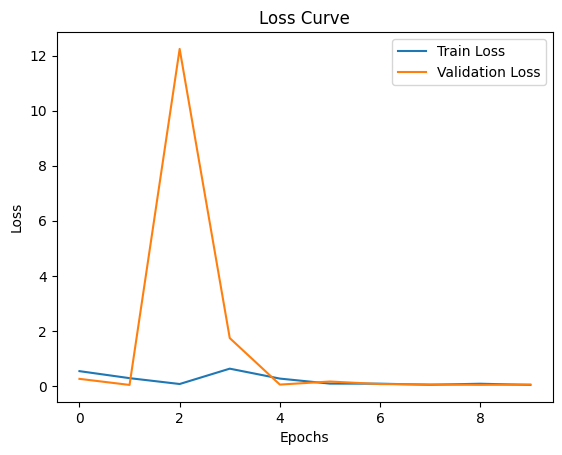

In [27]:
# 10. Plotting Loss Curves
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

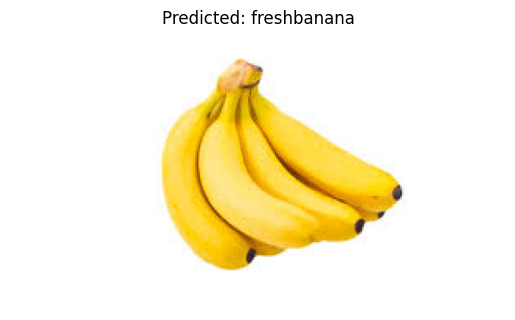

'freshbanana'

In [31]:
from torchvision.transforms.functional import to_pil_image

def predict_image(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
        class_label = class_names[predicted.item()]
    plt.imshow(image)
    plt.title(f"Predicted: {class_label}")
    plt.axis('off')
    plt.show()
    return class_label

# Usage
# Replace with the actual path to your image
image_path = "/content/bananafresh.jpg"
class_names = train_data.classes  # ['fresh', 'stale'] or similar
predict_image(image_path, model, val_transform, class_names)
